# Logistic Regression Baseline

This notebook establishes a classical ML baseline for financial sentiment analysis using:

-   **TF-IDF vectorization**
-   **Logistic Regression (with class weighting)**
-   **Macro-F1 and per-source evaluation**

This gives us a lightweight, interpretable baseline to compare with transformer-based models.


In [ ]:
import sys

sys.path.append("../scripts")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from metrics import per_source_metrics
from plot_utils import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Load Preprocessed Data

We’ll use the stratified training and validation sets saved in the previous step.


In [22]:
train_df = pd.read_csv("../data/processed/train.csv").dropna()
val_df = pd.read_csv("../data/processed/val.csv")

print(f"Train size: {train_df.shape}, Validation size: {val_df.shape}")
print("Columns:", list(train_df.columns), "\n")

display(train_df.head(2))
display(val_df.head(2))

Train size: (16088, 3), Validation size: (1788, 3)
Columns: ['sentence', 'label', 'source'] 



,sentence,label,source
0,The cooperation will involve Arena Partners bu...,neutral,FPB
1,LIVE NOW Press conference with FOMC Chair Powe...,neutral,Twitter


,sentence,label,source
0,Technopolis and the St Petersburg government s...,positive,FPB
1,Cleveland Fed President Loretta Mester said th...,neutral,Twitter


## Using Logistic Regression

We’ll use `LogisticRegression` from `sklearn` with class weighting to handle class imbalance. We’ll also use `TfidfVectorizer` for text vectorization.


### TF-IDF Vectorization

We use unigrams and bigrams (`ngram_range=(1, 2)`) and limit to the top 5,000 features.


In [23]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df["sentence"])
X_val = vectorizer.transform(val_df["sentence"])

print(f"TF-IDF matrix shape: {X_train.shape}")

TF-IDF matrix shape: (16088, 5000)


### Train Logistic Regression

We use `class_weight="balanced"` to handle any class imbalance.


In [24]:
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train, train_df["label"])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Evaluation

We evaluate on:

-   **Macro F1-score** (equal weight to all classes)
-   **Accuracy**
-   **Per-source performance** (e.g., FPB vs Twitter vs FiQA)


### Per-Source Evaluation

We calculate macro F1-score and accuracy for each source in the validation set. This helps us understand how the model performs across different data sources.


In [ ]:
val_preds = clf.predict(X_val)
# val_probs = clf.predict_proba(X_val) #TODO

# Print metrics by dataset source
lr_results = per_source_metrics(val_df["label"], val_preds, val_df["source"])
print("Per-Source Metrics (Logistic Regression):\n")
for source, acc, f1 in lr_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

Per-Source Metrics (Logistic Regression):

FPB: Accuracy=0.742, Macro-F1=0.704
Twitter: Accuracy=0.786, Macro-F1=0.725
FiQA: Accuracy=0.595, Macro-F1=0.497


### Classification Report

We generate a classification report with precision, recall, F1-score, and support for each class, and overall accuracy.


In [36]:
report = classification_report(val_df["label"], val_preds)
print("Full Report:\n")
print(report)

Full Report:

              precision    recall  f1-score   support

    negative       0.56      0.71      0.63       274
     neutral       0.87      0.82      0.84      1070
    positive       0.68      0.66      0.67       444

    accuracy                           0.76      1788
   macro avg       0.70      0.73      0.71      1788
weighted avg       0.77      0.76      0.77      1788



### Confusion Matrix

Visualizing misclassifications across classes helps us understand where the model struggles.


('TSLA STUDY the CHARTS PullbackTime', 'FiQA')
('HON Honeywell says MAX production freeze to hurt 2020 sales growth', 'Twitter')
('US Proved Oil Gas Reserves Hit New Record High', 'Twitter')
('Apple breaks major support here are some levels to watch AAPL QQQ', 'FiQA')
('NYSE owner ICE may gatecrash Deutsche BoerseLSE merger', 'FiQA')


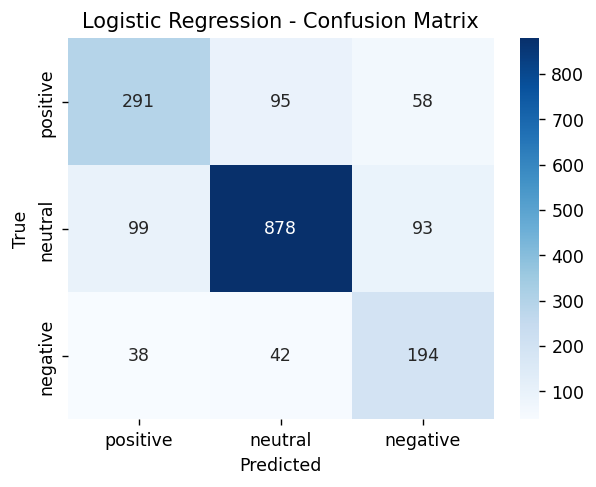

In [10]:
import pandas as pd
import sys

sys.path.append("../scripts")
from plot_utils import plot_confusion_matrix


val_df = pd.read_csv("../data/processed/val.csv")
val_preds = []
with open("../models/lr/lr-preds.txt", "r") as f:
    for line in f:
        val_preds.append(line.strip())
# show false positives for true negatives
fps = []
for i in range(len(val_preds)):
    if val_preds[i] == "positive" and val_df["label"].iloc[i] == "negative":
        fps.append((val_df["sentence"].iloc[i], val_df["source"].iloc[i]))
for i in range(5):
    print(fps[i])
plot_confusion_matrix(
    y_true=val_df["label"],
    y_pred=val_preds,
    labels=["positive", "neutral", "negative"],
    title="Logistic Regression - Confusion Matrix",
    cmap="Blues",
)

## Save Outputs

We’ll save:

-   TF-IDF vectorizer
-   Trained model
-   Classification report CSV and text predictions


In [ ]:
import pickle

from sklearn.metrics import classification_report

with open("../models/lr/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("../models/lr/logistic_regression_model.pkl", "wb") as f:
    pickle.dump(clf, f)

pd.DataFrame(
    classification_report(val_df["label"], val_preds, output_dict=True)
).transpose().to_csv(
    "../models/lr/lr-preds.csv"
)  # saving classification report as CSV

with open("../models/lr/lr-preds.txt", "w") as f:  # saving text predictions
    for item in val_preds:
        f.write(item + "\n")

## Summary

We trained a TF-IDF + Logistic Regression baseline model with the following results:

-   Macro-F1: Reported by class and source
-   Useful as a simple, interpretable baseline
-   All outputs saved in `/models/lr`

Next: Try transformer-based models like **FinBERT** in **[3_finbert_inference.ipynb](3_finbert_inference.ipynb)**.
